In [71]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

from collections import Counter
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from datasets import (load_dataset, 
                      load_metric, 
                      load_from_disk,
                      Dataset,
                      DatasetDict
)
# from transformers import (
#     AutoTokenizer,
#     BertModel, BertPreTrainedModel,
#     RobertaModel, RobertaPreTrainedModel,
#     AdamW, get_linear_schedule_with_warmup,
#     TrainingArguments,
# )

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
with open('../data/wikipedia_documents.json', "r", encoding="utf-8") as f:
    wiki = json.load(f)
    
wiki_corpus = list(
    dict.fromkeys([v["text"] for v in wiki.values()])
)

## 이상치

In [27]:
threshold = 10000

df = pd.DataFrame(doc_len)
df.columns = ['length']

is_over = df['length'] > threshold
over_length = df[is_over]
over_length

,length
578,14309.0
699,12517.0
973,25351.0
3249,10098.0
4529,27406.0
4531,19191.0
4533,41411.0
4534,46099.0
5540,10950.0
5953,29016.0


### 이상치 확인
한자, html 깨짐 유의 -> 토크나이징

In [28]:
idx_list = over_length.index.tolist()
for i, idx in enumerate(idx_list):
    print("passage",i, over_length.iloc[i])
    print(wiki_corpus[idx])

passage 0 length    14309.0
Name: 578, dtype: float64
;성도(청두)시 成都市

성도,간칭으로 “융”(蓉)이라고 도 한다. 아시에서 처음으로 국제“미식의 도시”(美食之都)로 이름이 났고 고대로 부터”천부지국”(天府之国)이라는 아름다운 명칭을 얻었다.. 이백(李白)의 시편 에는 “아홉개 하늘은 성도에서 나왔고 천만개의 문은 그림으로 들어 오너라” (九天开出一成都，万户千门入画图) 진절하게 금관성(锦官城)의 부유와 수려함을 묘사 하였다. 사천의 전통극은 절기하고 풍부하며 례로 타거(托举), 개혜안(开慧眼), 얼굴 변하기(变脸), 불뿜기(喷火), 칼숨기기(藏刀)등은 사람들로 하여금 감탄을 끓이지 않 았다. 성도는 2010년 2월 28일에 “미식의 도시”로 칭호를 수여 받았다. 성도의 유명한 소식(著名小吃)은 마퍼 두부(麻婆豆腐), 쌍류 토끼 두(双流兔头), 부처폐편(夫妻肺片), 단단면(担担面), 용 초수(龙抄手), 종 물 만두(钟水饺), 한 만두 떡(韩包子), 삼대 포(三大炮), 뢰탕원(赖汤圆)등이다. 성도의 가장 좋은 여행 시간은 3월, 4월, 5월, 6월, 9월, 10월, 11월이며 청성산(青城山), 서령 설산(西岭雪山), 구룡구(九龙沟), 구봉산(九峰山), 천대산(天台山), 용지 산림공원(龙池森林公园) 등은 모두 성도의 가장 이상적인 피서 명승지이다. 성도에서 북쪽으로 올라 가다 보면 도강언(都江堰), 구채구(九寨沟)로 도달할 수 있고 서쪽의 천장 도로(川藏公路)를 따라 올라 가면 라싸(拉萨) 로 통하며 촬영 성지인 경로에는 신도교(新都桥) 해라구 빙천(海螺沟冰川), 임지(林芝) 등지 망강(芒康)에서 남쪽으로 내려가다 보면 매리설산(梅里雪山), 샹그리라(香格里亚), 려강(丽江)등 주요 여행 경치 지역이 나타 난다.

;덕양시 德阳市
덕양은 역사가 유구하고 파촉문화 발원지 중의 하나이며 여행자원은 하늘의 두터운 특혜를 가져 독특하다. 국내외 에서도 유명한 국가 중점 문화물 보호 단위(国家重点文物保护单位)이며 국가 처음으로의

## train/val

In [74]:
mrc_datasets = load_from_disk('../data/train_dataset/')
mrc_train_dataset = mrc_datasets['train']
mrc_valid_dataset = mrc_datasets['validation']

In [34]:
mrc_train_dataset[0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

### dataframe 생성

In [75]:
# train data
_id = []  # 중복 확인용
doc_id = []
title = []
context = []
question = []
answer = []
answer_start = []
answer_len = []
question_len = []
context_len = []

for train_data in mrc_train_dataset:
    _id.append(train_data['id'])
    doc_id.append(train_data['document_id'])
    title.append(train_data['title'])
    context.append(train_data['context'])
    question.append(train_data['question'])
    answer.append(train_data['answers']['text'][0])
    context_len.append(len(train_data['context']))
    question_len.append(len(train_data['question']))
    answer_len.append(len(train_data['answers']['text'][0]))
    answer_start.append(train_data['answers']['answer_start'][0])
    
train_dict = {
    "id":_id,
    "doc_id":doc_id,
    "title":title,
    "context":context,
    "question":question,
    "answer":answer,
    "context_len":context_len,
    "question_len":question_len,
    "answer_len":answer_len,
    "answer_start":answer_start,
}

train_df = pd.DataFrame(train_dict)

In [76]:
# valid data
_id = []  # 중복 확인용
doc_id = []
title = []
context = []
question = []
answer = []
answer_start = []
answer_len = []
question_len = []
context_len = []

for valid_data in mrc_valid_dataset:
    _id.append(valid_data['id'])
    doc_id.append(valid_data['document_id'])
    title.append(valid_data['title'])
    context.append(valid_data['context'])
    question.append(valid_data['question'])
    answer.append(valid_data['answers']['text'][0])
    context_len.append(len(valid_data['context']))
    question_len.append(len(valid_data['question']))
    #answer_len.append(answer_len_f(valid_data['answers']['text']))
    answer_len.append(len(valid_data['answers']['text'][0]))
    answer_start.append(valid_data['answers']['answer_start'][0])
    
valid_dict = {
    "id":_id,
    "doc_id":doc_id,
    "title":title,
    "context":context,
    "question":question,
    "answer":answer,
    "context_len":context_len,
    "question_len":question_len,
    "answer_len":answer_len,
    "answer_start":answer_start,
}

valid_df = pd.DataFrame(valid_dict)

In [37]:
train_df.describe()

,doc_id,context_len,question_len,answer_len,answer_start
count,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000
mean,28399.783401,920.220648,29.322368,6.275051,376.794028
std,17475.051830,356.500514,8.727421,5.346842,309.122555
min,4572.000000,512.000000,8.000000,1.000000,0.000000
25%,11615.750000,645.000000,23.000000,3.000000,138.000000
50%,26295.000000,819.000000,29.000000,5.000000,310.000000
75%,44240.250000,1099.250000,35.000000,8.000000,538.000000
max,60603.000000,2059.000000,78.000000,83.000000,1974.000000


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3952 entries, 0 to 3951
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3952 non-null   object
 1   doc_id        3952 non-null   int64 
 2   title         3952 non-null   object
 3   context       3952 non-null   object
 4   question      3952 non-null   object
 5   answer        3952 non-null   object
 6   context_len   3952 non-null   int64 
 7   question_len  3952 non-null   int64 
 8   answer_len    3952 non-null   int64 
 9   answer_start  3952 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 308.9+ KB


In [40]:
valid_df.describe()

,doc_id,context_len,question_len,answer_len,answer_start
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,29027.704167,916.725000,29.195833,6.912500,391.516667
std,17915.733034,360.032122,8.728301,6.858755,311.943965
min,4866.000000,517.000000,9.000000,1.000000,0.000000
25%,11726.250000,616.750000,23.000000,3.000000,154.000000
50%,27485.000000,820.500000,29.000000,5.000000,317.000000
75%,44860.250000,1107.250000,35.000000,8.000000,536.000000
max,60305.000000,2064.000000,59.000000,64.000000,1429.000000


In [41]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            240 non-null    object
 1   doc_id        240 non-null    int64 
 2   title         240 non-null    object
 3   context       240 non-null    object
 4   question      240 non-null    object
 5   answer        240 non-null    object
 6   context_len   240 non-null    int64 
 7   question_len  240 non-null    int64 
 8   answer_len    240 non-null    int64 
 9   answer_start  240 non-null    int64 
dtypes: int64(5), object(5)
memory usage: 18.9+ KB


## train + val 데이터프레임 생성

In [77]:
total_df = pd.concat([train_df,valid_df], ignore_index=True)
total_df.head(3)

,id,doc_id,title,context,question,answer,context_len,question_len,answer_len,answer_start
0,mrc-1-000067,18293,미국 상원,"미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\n\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\n\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05",대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,하원,862,32,2,235
1,mrc-0-004397,51638,인사조직관리,"'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 1950년대이다. 2차 세계대전을 마치고, 6.25전쟁의 시기로 유럽은 전후 재건에 집중하고, 유럽 제국주의의 식민지가 독립하여 아프리카, 아시아, 아메리카 대륙에서 신생국가가 형성되는 시기였고, 미국은 전쟁 이후 경제적 변화에 기업이 적응을 해야 하던 시기였다. 특히 1954년 피터 드러커의 저서 《경영의 실제》는 현대적 경영의 기준을 제시하여서, 기존 근대적 인사조직관리를 넘어선 현대적 인사조직관리의 전환점이 된다. 드러커는 경영자의 역할을 강조하며 경영이 현시대 최고의 예술이자 과학이라고 주장하였고 , 이 주장은 21세기 인사조직관리의 역할을 자리매김했다.\n\n현대적 인사조직관리와 근대 인사조직관리의 가장 큰 차이는 통합이다. 19세기의 영향을 받던 근대적 경영학(고전적 경영)의 흐름은 기능을 강조하였지만, 1950년대 이후의 현대 경영학은 통합을 강조하였다. 기능이 분화된 '기계적인 기업조직' 이해에서 다양한 기능을 인사조직관리의 목적, 경영의 목적을 위해서 다양한 분야를 통합하여 '유기적 기업 조직' 이해로 전환되었다. 이 통합적 접근방식은 과정, 시스템, 상황을 중심으로 하는 인사조직관리 방식을 형성했다.",현대적 인사조직관리의 시발점이 된 책은?,《경영의 실제》,621,22,8,212
2,mrc-1-000362,5028,강희제,"강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전제 독재의 가능성이 보일 수도 있었으나, 스스로 황권을 조절하고 정치의 일부는 재상들이나 대신들과 의논하였으며 당시 궁핍하게 살고 있는 한족들의 사정을 잘 알고 있던 한족 대신들의 의견을 수용하여 정책을 실행하고 선정을 베풀었다. 프랑스의 예수회 선교사 부베는 루이 14세에게 다음과 같이 보고하였다. \n강희제는 세상에서 가장 부유한 군주입니다. 그럼에도 황제인 그의 생활용품들은 사치스러움과 화려함과는 거리가 멀다 못해 소박하기 그지없습니다. 역대 제왕들 가운데 전례없는 일입니다.\n강희제 스스로도 자신이 직접 쓴 《근검록》에서 다음과 같이 쓰고 있다\n모든 비용은 백성들의 피땀으로 얻어진 것이니 주인된 황제로서 절제하고 절제함은 당연한 것이 아닌가\n\n이런 강희제의 인자한 정치는 한족이 만주족의 청나라를 지지하게 만드는 데에 크게 일조하였다. 1717년(강희 56년) 강희제는 〈고별상유〉(告別上諭), 즉 마지막으로 백성들에게 바치는 글을 남겼는데 강희제는 “한 가지 일에 부지런하지 않으면 온 천하에 근심을 끼치고, 한 순간에 부지런하지 않으면 천추만대에 우환거리를 남긴다.”라고 역설하였다. 또한 “제왕이 천하를 다스림에 능력이 있는 자를 가까이 두고, 백성들의 세금을 낮추어 주어야 하며, 백성들의 마음을 하나로 묶고, 위태로움이 생기기 전에 나라를 보호하며, 혼란이 있기 전에 이를 먼저 파악하여 잘 다스리고, 관대하고 엄격함의 조화를 이루어 나라를 위한 계책을 도모해야 한다.”라고 후대의 황제에게도 이를 훈계하였다. 강희제는 황제로서 자식과 같은 백성들에게 이런 당부의 말을 남겨 황제로서의 도리를 다하려 하였다.",강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,백성,850,30,2,510


### duplicate

In [51]:
check_list = ['title', 'context', 'question']

In [52]:
print('train set')
for check in check_list:
    print(f'중복 원본까지 - {check}: {len(train_df[train_df.duplicated(check,keep=False)])}')
    print(f'중복되는 것만 - {check}: {len(train_df[train_df.duplicated(check)])}')
    
print('valid set')
for check in check_list:
    print(f'중복 원본까지 - {check}: {len(valid_df[valid_df.duplicated(check,keep=False)])}')
    print(f'중복되는 것만 - {check}: {len(valid_df[valid_df.duplicated(check)])}')
    
print('total data set')
for check in check_list:
    print(f'중복 원본까지 - {check}: {len(total_df[total_df.duplicated(check,keep=False)])}')
    print(f'중복되는 것만 - {check}: {len(total_df[total_df.duplicated(check)])}')


train set
중복 원본까지 - title: 1944
중복되는 것만 - title: 1236
중복 원본까지 - context: 1191
중복되는 것만 - context: 612
중복 원본까지 - question: 0
중복되는 것만 - question: 0
valid set
중복 원본까지 - title: 24
중복되는 것만 - title: 12
중복 원본까지 - context: 10
중복되는 것만 - context: 5
중복 원본까지 - question: 0
중복되는 것만 - question: 0
total data set
중복 원본까지 - title: 2152
중복되는 것만 - title: 1368
중복 원본까지 - context: 1336
중복되는 것만 - context: 688
중복 원본까지 - question: 0
중복되는 것만 - question: 0


train, val간에도 중복되는 문장 존재

## 그래프

In [78]:
train_df['doc_type']='train'
valid_df['doc_type']='valid'
concat_df = pd.concat([train_df,valid_df], ignore_index=True)

In [57]:
def draw_violin(type_len):
    fig, ax = plt.subplots(figsize=(16,9),nrows=2)
    ax=sns.boxplot(data=concat_df, x=type_len,y="doc_type",
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"},
                ax=ax[0])

    ax.set(xlabel=None) # 위에 있는 plot xlabel 삭제

    ax=sns.violinplot(data=concat_df, x=type_len,y="doc_type");
    plt.show()

In [55]:
concat_df.head()

,id,doc_id,title,context,question,answer,context_len,question_len,answer_len,answer_start,doc_type
0,mrc-1-000067,18293,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,하원,862,32,2,235,train
1,mrc-0-004397,51638,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,《경영의 실제》,621,22,8,212,train
2,mrc-1-000362,5028,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,백성,850,30,2,510,train
3,mrc-0-001510,34146,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,중국,727,39,2,625,train
4,mrc-0-000823,47334,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,4개,609,26,2,30,train


context_len



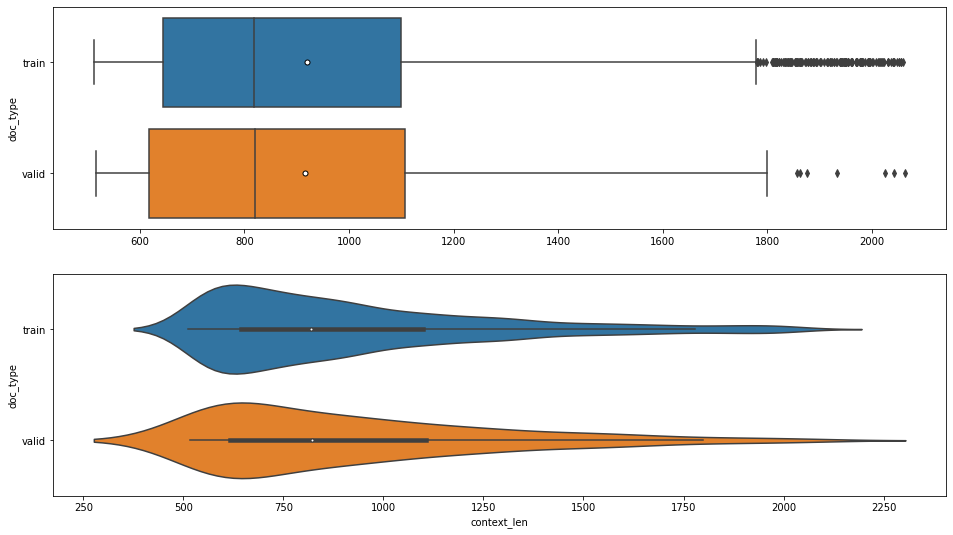

question_len



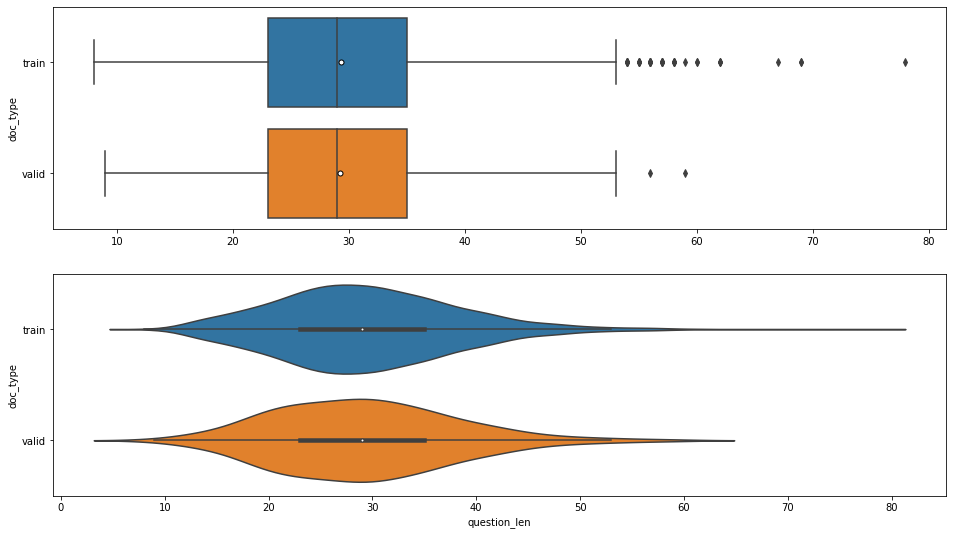

question_len



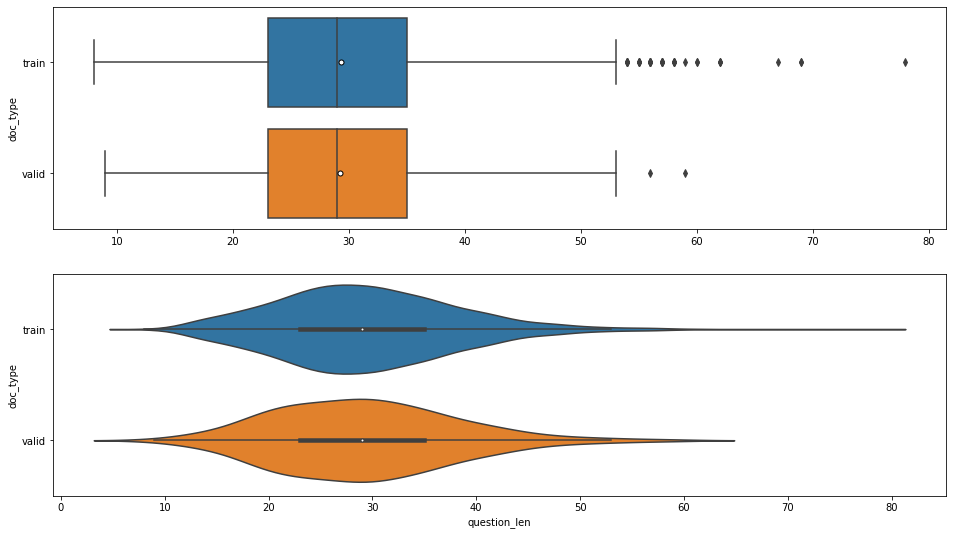

answer_len



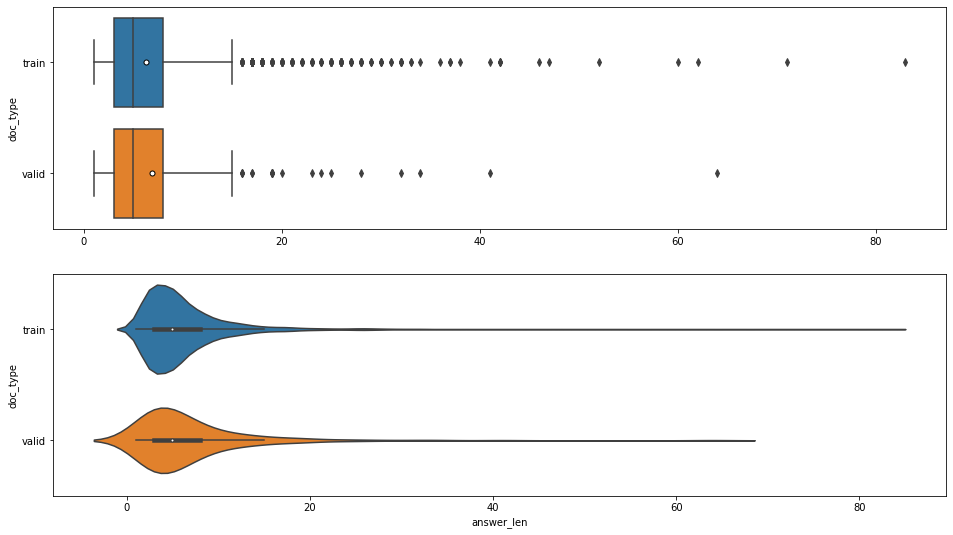

answer_start



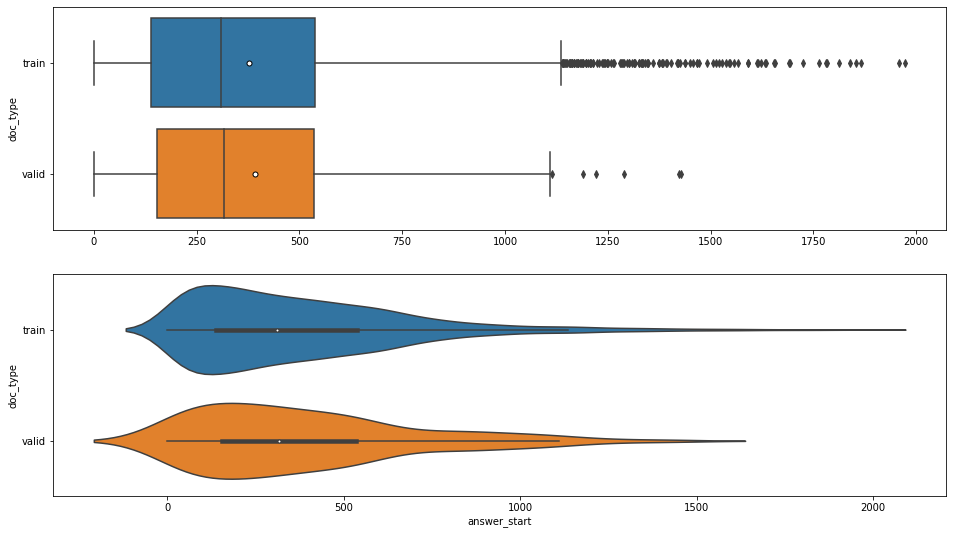

In [58]:
check_list = ['context_len','question_len','question_len','answer_len','answer_start']
for col in check_list:
    print(col+'\n')
    draw_violin(col)

In [66]:
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_214/3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [79]:
threshold = 65
col_name='question_len'
total_df[total_df[col_name] > threshold]

,id,doc_id,title,context,question,answer,context_len,question_len,answer_len,answer_start
958,mrc-0-004020,34582,카리용 전투,"7월 6일 아침, 영국 육군은 조지 호수의 북쪽 해안에 상륙을 시작했다. 에버크롬비는 먼저 상황을 확인하기 위해 선발 부대를 보내 일대를 조사하도록 했고, 최근 적군이 이 구역을 포기한 것을 알게 되었다. 서둘러 퇴각했기 때문에 프랑스군의 물자와 무기가 방치되어 있었다. 영국군은 대규모로 상륙한 후 종대로 정렬하여 조지 호수와 챔플레인 호수를 연결하는 지점으로 행군을 하려 했다. 수로보다 그쪽을 선택한 것은, 다리가 프랑스군에 파괴되어 있었기 때문이었다. 그러나 숲이 상당히 울창했기 때문에 대열을 유지하지 못했다.\n\n베르니츠 강이 라슈트 강과 합류하는 곳 근처에서 프랑스의 본대로 퇴각하던 트레뻬제 부대가 피네스 리먼이 이끄는 코네티컷 연대와 우연히 조우하여 교전을 벌였다. 그 근처에 조지 하우 장군의 대오도 있었기 때문에, 하우는 부대를 그곳으로 데려 갔다. 그들이 전투가 벌어지는 곳에 닿았을 때 하우 장군은 포탄에 명중하여 즉사했다. 또한 매사추세츠만 식민지의 병력도 이곳으로 몰려와 프랑스의 정찰별의 퇴각로를 차단했다. 이 고립된 싸움에서 트레뻬제 병사는 약 150명이 죽었고, 나머지 150명은 포로가 되었다. 트레뻬제를 포함한 포함 50명은 라슈트 강을 헤엄쳐 달아났다. 이날 교전에서 입은 상처로 트레뻬제는 다음날 죽었다.\n\n영국군 사상자의 수치는 일치하지 않는다. 윌리엄 네스터는 적게는 전사 10명에, 부상자가 6명이라고 주장했지만, 르네 차트랜드는 하우 장군을 포함해 100명 이상의 사상자가 나을 것이라고 주장한다. 울창한 숲으로 인해 어려움을 겪던 영국군은 하우 장군의 죽음에 사기가 저하되었고, 밤새 항해로 지쳐있었기 때문에 숲에서 야영을 하고, 다음 날 아침 상륙 지점으로 돌아왔다.","카리용 전투에서 영국 육군이 조지 호수 해안에 상륙했을 때, 그곳에 방치되어 있던 물자와 무기는 어느 나라 군대의 것이었나?",프랑스,852,69,3,128
1141,mrc-1-001657,25212,감사 (회계),"[이사및감사지위확인][공2017상,863]\n\n【판시사항】\n\n주식회사의 이사 또는 감사의 지위를 취득하기 위한 요건(=주주총회의 선임결의와 피선임자의 승낙) 및 이때 피선임자가 대표이사와 별도의 임용계약을 체결하여야 하는지 여부(소극)\n\n【판결요지】\n\n이사·감사의 지위가 주주총회의 선임결의와 별도로 대표이사와 사이에 임용계약이 체결되어야만 비로소 인정된다고 보는 것은, 이사·감사의 선임을 주주총회의 전속적 권한으로 규정하여 주주들의 단체적 의사결정 사항으로 정한 상법의 취지에 배치된다. 또한 상법상 대표이사는 회사를 대표하며, 회사의 영업에 관한 재판상 또는 재판 외의 모든 행위를 할 권한이 있으나(제389조 제3항, 제209조 제1항), 이사·감사의 선임이 여기에 속하지 아니함은 법문상 분명하다. 그러므로 이사·감사의 지위는 주주총회의 선임결의가 있고 선임된 사람의 동의가 있으면 취득된다고 보는 것이 옳다.\n\n상법상 이사는 이사회의 구성원으로서 회사의 업무집행에 관한 의사결정에 참여할 권한을 가진다(제393조 제1항). 상법은 회사와 이사의 관계에 민법의 위임에 관한 규정을 준용하고(제382조 제2항), 이사에 대하여 법령과 정관의 규정에 따라 회사를 위하여 그 직무를 충실하게 수행하여야 할 의무를 부과하는 한편(제382조의3), 이사의 보수는 정관에 그 액을 정하지 아니한 때에는 주주총회의 결의로 이를 정한다고 규정하고 있는데(제388조), 위 각 규정의 내용 및 취지에 비추어 보아도 이사의 지위는 단체법적 성질을 가지는 것으로서 이사로 선임된 사람과 대표이사 사이에 체결되는 계약에 기초한 것은 아니다. 또한 주주총회에서 새로운 이사를 선임하는 결의는 주주들이 경영진을 교체하는 의미를 가지는 경우가 종종 있는데, 이사선임결의에도 불구하고 퇴임하는 대표이사가 임용계약의 청약을 하지 아니한 이상 이사로서의 지위를 취득하지 못한다고 보게 되면 주주로서는 효과적인 구제책이 없다는 문제점이 있다.\n\n한편 감사는 이사의 직무의 집행을 감사하는 주식회사의 필요적 상설기관이며(제412조 제1항), 회사와 감사의 관계에 대해서는 이사에 관한 상법 규정이 다수 준용된다(제415조, 제382조 제2항, 제388조). 이사의 선임과 달리 특히 감사의 선임에 대하여 상법은 제409조 제2항에서 “의결권 없는 주식을 제외한 발행주식총수의 100분의 3을 초과하는 수의 주식을 가진 주주는 그 초과하는 주식에 관하여는 의결권을 행사하지 못한다.”라고 규정하고 있다. 따라서 감사선임결의에도 불구하고 대표이사가 임용계약의 청약을 하지 아니하여 감사로서의 지위를 취득하지 못한다고 하면 위 조항에서 감사 선임에 관하여 대주주의 의결권을 제한한 취지가 몰각되어 부당하다. 이사의 직무집행에 대한 감사를 임무로 하는 감사의 취임 여부를 감사의 대상인 대표이사에게 맡기는 것이 단체법의 성격에 비추어 보아도 적절하지 아니함은 말할 것도 없다.\n\n결론적으로, 주주총회에서 이사나 감사를 선임하는 경우, 선임결의와 피선임자의 승낙만 있으면, 피선임자는 대표이사와 별도의 임용계약을 체결하였는지와 관계없이 이사나 감사의 지위를 취득한다.\n\n(출처 : 대법원 2017. 3. 23. 선고 2016다251215 전원합의체 판결 [이사및감사지위확인] > 종합법률정보 판례)","의결권 없는 주식을 뺀 발행주식총수에서, 주주가 주식 몇 개를 보유해야 초과 주식에 대해 의사를 표명하지 못하게 되는가?",100분의 3을 초과하는 수,1617,67,15,1158
1207,mrc-0-004328,21298,오하이오강,"오하이오 강은 크기에 의하여 미시시피 강의 가장 큰 지류이다. 그곳은 약 1,579 km 길이이며 미국의 동쪽에 위치한다.\n\n강은 미국 원주민의 역사에 있어 큰 중요성을 가지고 있으며 때때로 켄터키와 인디언 영토 사이 경계로서 여겨진다. 그곳은 초기 미국의 서쪽으로 확장동안 주요한 운송 루트였다. 오하이오 강은 6개 주의 경계 통과하거나 따라서 흐르며 그곳의 유역은 그곳의 가장 큰 지류와 테네시 강을 통과하여 많은 미국 남동쪽 주를 포함하는 14개 주를 둘러싼다. 19세기 동안, 그곳은 북서부 영토의 남쪽 경계였으며 따라서 자유주와 노예주 사이에 경계로서 구실을 한다. 그곳은 때때로 펜실베이니아와 메릴랜드로부터 델라웨어와 (당시 버지니아의 일부) 웨스트버지니아를 나눴었던 초기의 메이슨-딕슨 선의 자연스러운 서쪽 확장으로서 흔하게 인정되기 때문에 메이슨-딕슨 선으로서 언급되며 그러므로 비공식적이며 때때로 미국 북부와 미국 남부 혹은 남부 고지대 사이에 경계로 논의 된다.\n\n오하이오 강은 그곳의 물이 온대 습윤 기후와 습윤 대륙성 기후의 주변을 따라 흐르기 때문에 기후 변화 지역이며 그 때문에 양 기후 둘 다의 동물군과 식물상이 거주한다. 1781년과 1782년에 출판된 토머스 제퍼슨의〈Notes on the State of Virginia〉는 ""오하이오는 지구상에서 가장 아름다운 강이다. 그곳은 흐름은 온화하며, 속은 매끈하며 바위에 의해 손상되지 않았으며 한 경우 만을 제외하고는 빠르다."" 라고 언급했다.",<Notes on the State of Virginia>에서 오아이오강이 지구상에서 가장 아름다운 강이라고 표현한 사람은?,토머스 제퍼슨,745,69,7,610
1840,mrc-0-004369,33393,면접교섭권,"면접교섭권은 1990년 민법 개정으로 신설된 제837조의2에 따라 1991년 1월 1일부터 부모에게만 주어지다가, 2007년 12월 21일 해당 규정이 개정되어 부모뿐만 아니라 자녀에게도 면접교섭권을 인정하였다. 대한민국의 판례는 이혼한 부모에 의해 갈려 따로 거주하는 자녀들 사이의 면접교섭권도 인정한다. 아동은 비양육 부모와 접촉, 대화, 서신교환, 전화, 선물 교환, 주말의 숙박, 방학 등의 일정 기간 체류 등 다양한 방법으로 자신의 비양육 부모와의 만남을 가질 수 있고, 비양육 부모는 아동과

In [69]:
threshold = 40
col_name='answer_len'
total_df[total_df[col_name] > threshold]

,id,doc_id,title,context,question,answer,context_len,question_len,answer_len,answer_start
520,mrc-0-000147,25654,판스워스 교수,"판스워스 교수는 배달원의 안전에 대해 별로 중요하게 생각하지 않으며, 첫 번째 에피소드에서 새로운 배달원들이 예전 배달원들이 어찌 되었는지 물어볼때 교수는 ""오 그 불쌍한 사람들... 그러나 그건 별로 중요하지 않아요! 중요한건 난 새로운 배달원이 필요했다는 거지!""라고 말한다. 교수는 종종 다른 배달회사에선 절대로 하지 않을 일에 그의 배달원들을 투입시킨다. 예를들어 마피아가 지배하는 세계에 소환장을 배달해준다던가, 사람을 죽이는 로봇이 점령한 행성에 소포를 배달한다든지 말이다. 플래닛 익스프레스의 슬로건은 다음과 같다. ""우리 배달원들은 바꿀수 있지만, 당신의 화물은 그렇지 않습니다"" \n\n또한 회사원들을 자신의 내장이라든가 혈액 대체품으로 생각하는 경향이 있다. 에이미 왕을 계속 인턴으로 붙잡아 두는건 그와 같은 혈액형이기 때문이며, 허미스 콘라드가 자살하려고 하던 에피소드에선 자살 하더라도 간엔 피해를 입히지 말라고 하며, 투랑가 릴라가 기절한 에피소드에선 장기를 적출하려고 통을 들고 오기까지 했다.\n\n판스워스 교수는 맘의 애인이자 고용인이었으, 두사람간의 의견차로 인해서 깨지게 된다. 한 에피소드에서 잠시 합쳐졌다가 다시 또 깨지게 된다. Bender's Game 에피소드에서 교수는 제일 싫어하는 맘의 아들인 이그너의 생부라는 것을 알게 된다.",판스워스 교수가 이전 배달원에 대해 한 대사는?,"""오 그 불쌍한 사람들... 그러나 그건 별로 중요하지 않아요! 중요한건 난 새로운 배달원이 필요했다는 거지!""",657,26,62,87
582,mrc-1-000394,4926,소크라테스 이전 철학자,"소크라테스 이전 철학자(독일어: Vorsokratiker, 영어: Presocratics)란 문자 그대로 소크라테스 이전에 살았던 고대 그리스의 철학자를 한데 묶어서 쓰는 낱말이다. 이 낱말은 처음 독일의 고전 문헌학자 헤르만 딜스가 이들 철학자의 단편들을 한데 모아 엮은 책의 제목에서 비롯된다. 그 뒤, 영어와 프랑스어에서 독일어를 직역하여 그대로 쓰고 있으며, 오늘날 서양 철학사에서 굳어진 낱말이라고 볼 수 있다. 이들은 흔히 고대 그리스의 자연 철학자라고 불리기도 하며, 또는 그들이 태어난 지방의 이름을 따서 이오니아, 엘레아 철학자 등으로 일컫기도 한다.\n\n소크라테스 이전 사상에 대한 중요한 분석들은 그레고리 블라스토스, 조너선 번스, 고든 클라크 그리고 프리드리히 니체의 책 《그리스 비극 시대의 철학》에 의해 다루어졌다.\n\n그들 대부분은 중요한 문헌들을 남겼다고는 하지만, 그 문헌들이 완성된 형태로 남아 있지는 않다. 우리가 알고 있는 모든 것들은 후대의 철학자들과 역사학자들에 의해 인용되었던 것들과 단편적으로 남아 있는 문헌들뿐이다.\n\n소크라테스 이전 철학자들은 그들 주위에서 벌어지는 현상에 대해 전통적으로 행해지던 신화적 해석들을 거부했으며, 대신 좀 더 이성적인 해석을 내놓았다. 그들 대부분은 다음과 같이 물었다:\n\n* 만물은 어디에서 유래하는가?\n* 만물은 무엇으로부터 창조되었는가?\n* 자연에서 발견되는 사물들의 다수성은 어떻게 설명해야 하는가?\n* 자연은 수학적으로 어떻게 기술해야 하는가?\n\n일부는 나중에 수학적, 과학적 그리고 철학적 연구의 기초가 되는 문제들과 역설들을 정의하는 데 집중했다. 물론, 초기의 그리스 철학자들에 의해 제기된 우주론은 근대 과학에서 기초된 관점에 의해 수정되었다. 그 이후의 철학자들은 대부분 그들이 내놓은 대답들은 받아들이지 않았지만, 그들이 물었던 질문들은 이후 철학자들에게도 여전히 중요한 문제였다.",영어로 Presocratics란 뜻을 가진 낱말의 기원은?,독일의 고전 문헌학자 헤르만 딜스가 이들 철학자의 단편들을 한데 모아 엮은 책의 제목,950,32,47,111
996,mrc-0-002792,5307,윤치호,"3·1 운동\n1919년 3월 3·1 운동 당시, 독립운동가들로부터 국민대표로 서명을 권유받았으나 거절했고, 이는 실망한 일부 학생들로부터 비판을 받게 된다. 그는 이 민족적인 거사를 순진한 애국심에 기초한 민족주의자들의 무모한 행동으로 파악했다. 그는 한일병합 이후에도 신문과 방송매체를 통해 선전, 선동을 하는 지식인들을 혐오하고 경멸했다. 윤치호에 의하면 그들은 '자신들은 죽을 용기도 없으면서 다른 순진한 사람들을 죽음의 골짜기로 몰고 가는 저주받을 악마와 같은 존재들'이었다.\n\n이번 운동에 반대하는 세 가지 이유는 이렇다. 조선 문제는 파리강화회의에 상정되지 않을 것이다. 어떤 나라도 조선독립을 위해 일본과 싸우는모험을 감행하지는 않을 것이다. 약자가 취할 수 있는 최선의 방책은 강자의 호감을 사는 것이다|1919년 3월 6일\n\n그는 젊은이들을 무책임하게 죽음으로 몰고간다며 일부 민족대표와 독립운동가를 무책임한 인사라고 비판했다. 오히려 그는 이러한 선동이 독립을 불러오기는커녕 일본 제국주의자들에게 한국인들을 더욱 가혹하고 엄하게 다룰 구실만 제공할 뿐이라고 내다봤다.\n\n 3.1 만세 운동의 실패를 예견한 그는 만세 운동이 한참 진행 중이던 3월 2일자의 일기에서 학생들을 앞세운 뒤, 만세 대열에서 슬그머니 발을 뺀 기독교, 천도교계 인사들을 음모꾼들이라며 규탄했다 3ㆍ1운동 후 구치소에 수감되는 여학생들의 모습에서는 일제 경찰에 대한증오와 분노로 밤새워 괴로워했다 이후 3월 5일~3월 7일 그는 시내를 다니며 만세 시위 직후의 동태를 파악했다. 3월 7일 기자 회견을 통해 다음과 같은 담화문을 발표하기도 했다.\n\n강자와 서로 화합하고 서로 아껴 가는 데에는 약자가 항상 순종해야만 강자에게 애호심을 불러일으키게 해서 평화의 기틀이 마련되는 것입니다마는, 만약 약자가 강자에 대해서 무턱대고 대든다면 강자의 노여움을 사서 결국 약자 자신을 괴롭히는 일이 됩니다. 그런 뜻에서도 조선은 내지에 대해서 그저 덮어 놓고 불온한 언동을 부리는 것은 이로운 일이 못됩니다.|윤치호|경성일보 1919년 3월 7일\n\n이 상황에 대해서, 일부 학자는 그 당시에, 윤치호가 '(조선의) 독립은 불가능하며 일제에 저항을 할 필요가 없다고 생각'했다고 주장한다. 자신의 일기에도 “나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”(윤치호 일기, 1919년 10월 1일자)라고 썼다. 이때문에 일부 독립운동 지도자들로부터 비난을 받기도 했다. 한편 3·1 만세 운동을 주도한 민족대표의 1인인 권동진을 만났는데, 윤치호는 그로부터 처음에는 평화적인 선언서 낭독으로 이를 통해 신문 뉴스로 국제사회에 한국의 독립을 알리기로 결정했으나 학생들이 갑자기 감정이 격해져서 감정적인 시위로 변질됐다는 이야기를 듣게 된다. 권동진이 처음 찾아왔을 때 그는 경멸적인 태도로 대하였으나, 그의 이야기를 듣고 다소 감정적인 태도에서 한발 누그러졌다.\n\n호찌민의 실패를 예견한 그는 파리강화회의에 기대를 거는 한국인 독립운동가들의 기대 역시 좌절될 것이라고 내다봤다. 파리강화회의에서 한국 문제는 상정되지 않았고, 이후 김규식, 여운형 등은 소련 등 사회주의세력에, 송진우 등은 실력양성론으로 노선을 전환한다.",윤치호가 일부 독립운동 지도자들로부터 비난 받았던 일기의 내용은?,“나는 국경일에 일장기를 게양하는 것을 반대하지 않는다. 왜냐하면 우리가 일본의 통치하에 있는 한 우리는 그 통치의 명령에 복종해야 하기 때문이다.”,1633,36,83,1122
1073,mrc-0-003659,5281,윤치호,"그는 곧 밴더빌트 대학교 신학부에 입학하였다. 밴더빌트 대학교 재학 중에 그는 감옥의 수인선교를 위해 1년 6개월간 매주일 오후에 형무소를 방문하여, 미국인 죄인들에게 기독교 강론이나 성경을 가르쳤다 조지아주에 가서는 가난한 흑인들에 비참한 생활에 관심을 가지며 그들에게 개신교를 전도하기도 했다\n\n한편으로 그는 학비걱정이나 일본 학생친구들과의 대화,

In [70]:
threshold = 1750
col_name='answer_start'
total_df[total_df[col_name] > threshold]

,id,doc_id,title,context,question,answer,context_len,question_len,answer_len,answer_start
155,mrc-0-002952,4978,갈릴레오 갈릴레이,"갈릴레오는 실험과 수학의 혁신적인 조합을 통해 운동에 관한 과학에 기여를 했다. 당시 더욱 전형적이었던 과학은 자기와 전기에 관한 윌리엄 길버트(William Gilbert)의 성질 연구였다. 류트 연주자이자 음악 이론가였던 갈릴레오의 아버지 빈센초 갈릴레이(Vincenzo Galilei)는 물리학에서 아마도 가장 오래된 비선형 관계로 알려진 팽팽하게 당겨진 줄에서 음색이 장력의 제곱근에 따라 달라진다는 것을 성립함을 보이는 실험을 시행하였다. 이러한 관찰은, 악기 제작자들에게도 잘 알려져있고, 현을 구멍의 번호에 따라 나누면 화음을 제공한다는 사실 또한 포함하는 피타고라스 학파의 음악에 대한 기초에 근거한다. 따라서 제한된 양의 수학만이 음악과 물리학을 연관지어왔고, 젊은 갈릴레오는 그 전통의 확장에 따른 그의 아버지의 관찰을 볼수 있었다.\n\n철학은 우주라는 드넓은 책에 쓰였다. … 그것은 수학의 언어로 쓰였으며 그것의 문자는 삼각형, 동그라미와 다른 기하학적 수치들이다.|《분석자》( \n\n그의 수학적 분석들은 그가 철학을 공부하면서 배운 스콜라 자연 철학가들에 의해 만들어진 전통을 더욱 발전시킨 것이다. 비록 그는 로마 가톨릭 교회에 충실하고자 했지만, 그의 실험결과에 대한 집착과 결과들에 대한 정직한 해석들은 과학적인 면을 철학 또는 , 종교적인 권위에 대한 충성을 거절하는 것처럼 유도되었다. 하지만 조금 광범위한 관점에서 볼 때, 이는 과학을 철학과 종교로부터 분리시키는 것을 거들었다. 이는 인간의 사고에 주된 발전 중에 하나였다.\n\n그가 살던 시대의 기준으로 볼 때, 갈릴레오는 때로 자신의 관측에 따라 견해를 자주 바꾸는 사람이었다. 과학 철학자 폴 파이어아벤드(Paul Feyerabend) 또한 갈릴레오의 방법론의 부적절한 측면들을 언급했다. 하지만 그는 갈릴레오의 방법들이 자신들의 연구에 의해 소급하여 정당화 될 수 있다고도 언급했다.\n파이어아벤드의 주요 저서인 Against Method(1975)는 갈릴레오의 이론을 분석하였으며, 갈릴레오의 천문학적 관측 결과는 그간의 과학적 방법을 전복시키기 위한 파이어아벤드의 주장을 뒷받침하는 데 이용되었다. 파이어아벤드는 ""갈릴레오주의자들이 닿기 힘들고, 지지받지 않고, 부분적으로 부인되는 이론들에 만족을 할 때, 아리스토텔레스주의자들은 충분한 경험적 근거들을 요구한다. 나는 이러한 사실 때문에, 갈릴레오주의자들을 비난하지는 않는다. 반면에 나는 닐스 보어의 '그것은 충분히 미치지 않았어'라는 말을 선호한다.""라고 쓰고 있다. 실험을 수행했을 때, 서로 다른 실험 장소에서 서로 다른 날에 실행된 실험들이 제 생산 가능한 방식에서 비교될 수 있도록, 갈릴레오는 단위 길이나 단위 시간을 설정했어야만 했다.\n\n갈릴레오는 수학과 이론 물리학 그리고 실험 물리학 사이에 적절한 관계에 대해 뚜렷한 인식을 보여주었다. 그는 포물선을 원뿔꼴의 관점에서, 그리고 좌표 y가 x의 제곱근에 의해 달라진다는 점에서도 바라보았다. 갈릴레오는 더 나아가 마찰과 다른 저항이 없는 상태에서 일정하게 가속된 발사체의 이론적으로 이상적인 궤도가 포물선이라는 점도 내세웠다. 그는 지구와 비교할 수 있는 발사체의 궤도가 포물선일 수는 없다는 이론적 배경에 한계가 있다는 점은 인정했지만, 그럼에도 불구하고 그의 시대에 대포를 통해 포탄이 나갈 수 있는 거리의 범위 안에서 포물선을 통해 얻은 발사체의 궤도와의 차이는 매우 작을 것이라고 했다. 세 번째로 그는 그의 실험 데이터들이 부정확한 측정과, 줄일 수 없는 마찰들, 그리고 다른 요인들 때문에 이론적, 수학적 결과들과 일치하지 않을 것이라는 것을 인식하기도 했다.\n\n스티븐 호킹은 갈릴레오가 누구보다도 현대 과학의 탄생에 책임이 많다고 말했으며 , 알베르트 아인슈타인은 그를 현대 과학의 아버지라고 했다 .",갈릴레오를 현대 과학의 아버지라 칭한 사람은?,알베르트 아인슈타인,1871,25,10,1839
733,mrc-0-003695,59462,파양호 대전,"아흐레만에 주원장의 선단은 남창에 도착했다. 파양호로 이동한 진우량의 선단은 대형 전함을 모아 배와 배를 사슬로 잇고 진을 치고 있었다.\n\n주원장의 선단은 모두 11개 부대로 편재되어 대선이 가운데 있고 소형 선박들을 중심으로 화력을 중시하고 있었다. 나머지 보병대는 남창에 상륙해 남창의 수비군을 지원하였다. 나아가 주원장은 결전이 있기 나흘 전에 복병을 호수 어귀에 숨겨 두었다. 7월 20일(양력 8월 29일) 양군의 주력 부대가 파양호에서 대치, 다음날 새벽에 전투가 시작되었다. 이보다 사흘 전에 주원장측은 군선이 작고 병사도 적어서 열세에 처해 있었고, 진우량의 대형 전함인 누선이 높은 위치에서 돌을 날리며 주원장측의 군선을 공격하고 있었다. 이 공격으로 주원장 자신이 탄 배도 파손되어 위험에 처하였으나 금의위(錦衣衛) 소속 전선에 의해 주원장은 무사할 수 있었다.\n\n소형 선박이 많았던 주원장의 선단은 이러한 진우량의 대형 전함의 공격에 두려움을 느꼈기에 싸움은 불리하였으며, 진우량의 부하로 용장(勇將)으로 이름난 장군 장정변(張定辺)이 일시에 주원장의 기함(旗艦)에 육박해 들어 오는 등 고전하였다. 그러나 진우량측은 앞서의 남창에서의 장기 포위전으로 지쳐 있었고, 주원장이 곽흥(郭興)의 건의를 받아들여 화공(火攻)과 투석기를 사용하기 시작했다. 유통해(兪通海)가 거느리는 화포(火砲) 선단이 둔중한 진우량의 선박들을 차례대로 불태우는 등, 싸움의 주도권은 서서히 주원장에게로 옮겨가고 있었다. 전투 나흘째(양력 9월 2일)에 이르렀을 때 진우량측의 누선과 함선 20여 척이 불탔고, 최소한 2만 5천 명에 이르는 진우량측 군사들이 전사했다. 진우량의 동생인 진우인(陳友仁)、진우귀(陳友貴) 및 그 평장(平章) 진보략(陳普略) 등도 전사했다.\n\n또한 전투 사흘째, 갑자기 불어온 동북풍에 주원장은 결사대로 조직한 화선(火船) 일곱 척을 진우량 함대로 돌진시켰고, 때마침 불어온 강풍으로 밀집해 있던 대형 선박들은 불타버렸다. 「연기와 불꽃은 하늘에 가득하고, 호수는 여기저기 핏빛으로 물들었다」는 지옥도가 연출되고 있었다. 진우량의 군은 참수된 자가 2천여 급에 물에 빠져 죽거나 불에 타 죽은 자도 셀 수 없을 정도였으며 거의 궤멸적인 피해를 입고 물러나게 되었다. 나아가 진우량의 동생으로 용맹과 지략이 뛰어나다는 평을 받고 있던 진우인이 이 전투에서 사망한 것은 진우량 군대의 사기를 급격히 저하시켰다.\n\n파양호는 가을 햇볕으로 인해 수위가 낮아져 있었고, 진우량의 군이 거느리고 온 대형 선박들은 습기를 많이 흡수해 무거워져서 호수 바닥에 닿기도 하는 등의 이유로 물가에 닿을 수 없었다. 주원장의 선단에 속한 배들은 작고 속도가 빨라 공격이 유리하였고 물가에 접안해 오랫동안 버티며 싸울 수도 있었다. 8월 하순에 주원장의 육군이 남창을 구해냈으며 일부 주원장측의 군사들이 감강(贛江)、장강(長江) 등지로 철수하고 일부 함대는 남아서 진우량의 군대와 계속 싸우며 보병이 와서 수륙(水陸) 포위망을 완성하기를 기다리고 있었다. 그리고 8월 26일(양력 10월 4일) 진우량은 주원장군의 포위망을 돌파해 무창으로 도망치려 했으나 주원장이 호수 어귀에 숨겨 두었던 복병에 가로막혀 또 다시 며칠 동안 대치하지 않으면 안 되었다. 병참선도 끊어지고, 진우량의 군대에서는 쓰러져 죽거나 달아나는 자가 속출하였다. 진우량은 호수 어귀를 돌파하려다 화살에 맞아 전사했다. 진우량이 거느리고 왔던 군세 가운데 2만 명이 죽고 50만 명의 군사들은 무너져 흩어져버렸다 일부가 무창으로 돌아오는데 성공했으나, 대장을 잃은 공백은 컸고, 이듬해 2월 주원장은 군사를 거느리고 무창을 포위 공격했다. 결국 그 아들 진리(陳理)가 1364년에 주원장에게 항복하였다. 이로써 주원장은 진우량이 거느리고 있던 장강 중류의 광대한 지역을 점령하게 되었다. 그러나 이 전투에서 주원장측도 7천여 명의 병사를 잃었

In [80]:
threshold = 2000
col_name='context_len'
total_df[total_df[col_name] > threshold]

,id,doc_id,title,context,question,answer,context_len,question_len,answer_len,answer_start
288,mrc-1-000061,56688,다이쇼 로망,"다이쇼 로망( ロマン}})은 다이쇼 시대의 문화현상이다. 종종 다이쇼 낭만(大正浪漫)이라고도 표기된다. 19세기 유럽에서 전개된 정신운동인 로망주의(= 낭만주의)의 영향을 받아(""로망""을 ""낭만""으로 옮긴 것은 나츠메 소세키가 처음으로 알려져 있다) 다이쇼 시대의 개인해방과 신시대의 이상주의가 만연한 듯한 풍조를 이렇게 부르게 되었다. 다만 일본의 낭만주의 자체는 메이지 말기에 시작하여 다이쇼 초기 자연주의로 전환되어 끝났다.\n\n다이쇼 시대는 15년간으로 짧지만 국내외 격동의 시대였다. 일본은 청일전쟁과 러일전쟁의 2차례 전승을 거쳐 제국주의 5대국의 반열에 들게 되었고, 제1차 세계대전에 참전, 역시 승전국이 되면서 국위선양의 분위기가 들끓던 시대였다. 서유럽 선진국의 산업혁명의 영향을 받아 메이지 시대 45년간 진행된 산업화 덕에 경제는 꾸준히 발전했고, 유통과 상업이 비약적으로 발전했다. 철도망 형성과 증기선 수운이 발달, 이에 병행하여 마을과 도시의 기반이 형성되었다. 다이쇼 시대 들어서는 근교철도가 부설되고 도로망이 확대되면서 자동차와 승합버스 같은 도시 내 교통수단도 발전, 도시화가 촉진되었다. 녹음과 활동사진의 출현, 전보와 전화기술의 발달, 그리고 새로운 인쇄기법에 의핸 대중을 위한 신문・서적・잡지의 보급 등이 새로운 미디어가 되면서 문화・정보의 전파도 확대적으로 도약했다.\n\n경제적으로는 상인의 지위가 메이지 시대의 경제자유화와 함께 상승했다. 서양에서 배워온 회사제도가 발달하면서 사기업이 발전, 선진국에 진입하면서 일본 기업들은 세계를 향해 대규모화해 나간다. 또한 왕성한 일본 시장을 겨냥한 웨스팅하우스 일렉트릭, 유니버설 픽처스 등 구미 기업의 진출이 잇따랐다. 1차대전 승전의 결과 패전국 독일로부터 남양군도를 뜯어와 그 땅의 개척도 진행되었다. 또한 대전경기와 투기의 성공으로 졸부(成金) 계층이 등장하면서 입신출세의 야망이 관직 뿐 아니라 사업을 향해서도 열리게 되었다.\n\n중산층 사이에는 다이쇼 데모크라시 민본주의가 대두, 일반 민중과 여성의 지위향상을 꾀하게 되었고, 서양 문화의 영향을 받은 새로운 문예・미술・음악・연극 등 예술이 유포되어 사상적으로도 자유와 개방의 역동적인 분위기가 만발했다. 도시를 중심으로 수입산 애호, 대중문화와 소비문화가 꽃을 피웠다. 하지만 농촌지역은 아직도 근대화가 진행 중이었으며 메이지 초기와 변함없는 봉건적 문화가 유지되었다.\n\n그러나 다이쇼 시대 후반 들어 전후 공황과 관동대지진 등으로 인한 경제의 심한 기복, 새 시대의 급격한 변화에 대응할 수 없는 스트레스도 표면화된다. 도시화와 산업화는 방대한 노동자계급을 만들어냈고, 해외의 사회변혁운동에 호응한 사회주의 운동이 큰 파도가 되어 지배층을 위협했다. 또한 부유계층에서도 아직 극복되지 않은 폐결핵 등의 질병에 의한 유명인사의 죽음도 어두운 그림자를 드리웠다. 지식인 사이에서는 개인주의와 이상주의가 강하게 의식되면서 새로운 시대로의 도약에 마음 설레면서도 동시에 사회불안에 시달리는 심리적 마찰이 있었다. 쇼와 시대에 유행한 자유연애와 동반자살, 작가나 예술가의 자살 같은 것이 유행하기 시작한 것도 이 무렵부터다.\n\n대중매체의 유포와 함께 정보의 증폭이 전해져 시대의 불안에 어떤 종류의 퇴폐적이고 허무적인 분위기도 자아졌다. 이 배경에는 19세기 후반에 유럽에서 흥한 유미주의와 다다이즘의 영향도 엿보인다. 예술작품은 아르누보와 아르데코, 표현주의 등 세기말 예술의 영향을 받은 것도 많았다. 한편 공산주의나 무정부주의 같은 ""위험사상""은 단속, 압박의 대상이 되었다.\n\n""다이쇼 로망""은 신시대의 맹아를 나타내는 의미에서 모더니즘(근대화)에서 파생된 다이쇼 모던(大正モダン)이라는 말과 동렬로 취급되기도 한다. 화려하지만 퇴폐적이고 불안했던 ""다이쇼 로망""은 ""다이쇼 모던""과 동시대의 앞뒷면 관계라고 할 수 있다. 재위가 짧았던 다이쇼 천황이 승하하고 지진재해 등에 의한 경제의 폐색감과 함께 다이쇼 시대가 끝난다. 이후 세계 대공황과 함께 쇼와 시대가 열리지만, 다이쇼 모던의 흐름은 단절되지 않고 쇼와 모던으로 이어진다.",사회주의 운동을 지지하며 전개해나간 계층은 누구인가?,노동자계급,2013,29,5,1289
565,mrc-0-002935,38852,이호영 베드로,"이호영은 1803년 경기도 이천에서 태어났고 부친을 여읜 후 서울로 이사했다. 그의 가족은 극심한 가난에 시달렸지만 평화로웠다. 그는 이경언 바오로를 찾아가 스승으로 모시고 그로부터 많은 것을 배웠다. 이경언은 조선왕조의 제3대 왕 태종의 15세손이며 이경도 가롤로와 이순이 루갈다의 막내 남동생이다. 이경언은 1827년에 체포될 때까지 이호영을 가르쳤다. 청주로 압송된 그는 가장 끔찍한 고문을 받고 감옥에서 숨을 거두었다. 그의 순교는 이호영에게 신념의 진정한 의미를 가르쳤다\n\n1834년 1월, 유방제 파치피코 신부가 청나라에서 조선으로 입국했다. 그는 1801년 국내 최초의 외국인 사제 주문모 야고보 신부 가 순교한 이래 33년만의 첫 사제이다. 당시 조선의 천주교인들은 대단히 기뻐했으며 그들의 행복은 말로 표현할 수 없었다. 그들은 처음으로 고해성사와 영성체를 받았다. 유방제 신부는 이호영에게서 헌신적이며 온유하고 정직한 자질을 발견해, 그를 교리 교사로 임명했다. 이호영은 어느날 과거 시험에 급제하는 꿈을 꾸었다. 그는 꿈 속에서 아름다운 음악을 들었고 누군가가 왕의 총신이 그를 사랑한다고 말했다. 이호영은 그 꿈이 자신의 순교에 대한 암시라고 여겼다. 실제로, 1835년 2월의 어느날, 그가 일터에서 돌아왔을 때, 한 무리의 포졸들이 기다리고 있었고 그를 체포했다. 이호영은 4년 동안 옥살이를 하며 온갖 종류의 고문과 고난을 겪었다. 그는 한 편지에다 그가 받은 몇 개의 질문과 그의 답변을 남겼다.\n\n\n\n재판관은 그의 다리뼈가 튀어나올 때까지 주뢰를 틀었으며 배교를 강요했다. 그러나 이호영은 말했다. ""저는 절대로 하느님을 부인할 수 없습니다."" 재판관은 형리를 시켜 그의 허리와 다리에 매질을 가하며 그에게 말했다. ""만일 네가 소리지른다면, 나는 그것을 네가 배교한 것으로 간주하겠다."" 이호영은 소리를 내지 않았다.\n\n《기해일기》에서는 ""도살장으로 끌려가는 어린 양처럼 그는 혹독한 매질의 고통 속에서도 입 한번 열지 않았다""고 전한다.\n\n그는 자신이 옥중에서 병으로 죽는 것이 하느님의 뜻이라면 기꺼이 그렇게 하겠다고 말했다. 4년이라는 긴 투옥 기간 동안, 그는 기도와 단식을 계속하였으며 선량함과 순박함의 모범을 보여 옥졸들과 동료 죄수들이 찬탄하였다. 그와 옥방을 같이 사용하던 한 늙은 죄수가 그에게 감명받아 과거를 뉘우치고 세례를 받기 위해 이호영에게 교리 수업을 받았다. 이호영과 그의 누나 이소사는 각자 다른 옥방에 수감되어 있었음에도 불구하고, 옥졸들은 때때로 그들을 서로 만나게끔 해 주었는데, 그 때마다 그들은 서로를 격려했고 같은 날에 순교자로서 죽기를 약속했다. 하지만, 그는 병약함에 의해서 서서히 죽어갔고 그의 누나보다 먼저 목숨을 잃었다.\n\n1845년에 조선에 입국해서 후일에 국내에서 다섯번째로 주교가 된 안토니오 다블뤼 신부와 1877년에 투옥된 펠릭스 리델 주교는 수감생활에 대하여 기술했다.\n\n천주교인들은 하나의 옥방에 너무 많이 수감되어 있었기 때문에 누워 있을 수 없었다. 그들은 모두 수감생활이 고문보다 더 가혹하다고 여겼다. 피와 고름 그리고 바닥에 깔린 짚에서 나는 악취로 인해 그들은 빠르게 병에 걸렸고, 몇 명은 이삼일 내에 죽었다. 그러나, 그것들 중 가장 심각한 것은 굶주림과 목마름이었다. 고문을 견뎌낸 적지 않은 수의 사람들도 나중에는 굶주림으로 인해 굴복했다. 그들은 하루에 겨우 두 줌의 밥으로 연명하며, 때때로 바닥의 짚을 찢어서 씹거나 옥방에 서식하는 이를 잡아 먹었다.|다블뤼 주교\n\n나는 굶주림으로부터 오는 그러한 고난을